# DM4ML — Prepared Dataset: Summary & Visualizations

This notebook loads `prepared.csv` (expected at repository root / current working directory),
prints summary statistics, and generates meaningful visualizations for churn EDA.

**Assumptions**
- Dates are parseable; `ingest_ts` uses format `%Y-%m-%d-%H:%M:%S` (e.g., `2025-08-17-16:56:02`).
- `churned` is 0/1.
- `subscription_plan_le` is a label-encoded integer (e.g., 0,1,2).


In [1]:

# --- Setup & Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Inline plots
%matplotlib inline

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")
print("Libraries imported.")


Libraries imported.


In [2]:

# --- Load Data ---
PATH = "prepared.csv"  # Assumes the file is present in the working directory

# Read without date parsing first to handle custom formats robustly
df = pd.read_csv(PATH)

# Parse dates where present
def parse_date(col, fmt=None):
    if col in df.columns:
        if fmt is None:
            df[col] = pd.to_datetime(df[col], errors="coerce")
        else:
            df[col] = pd.to_datetime(df[col], format=fmt, errors="coerce")

parse_date("asof_date")
parse_date("signup_date")
parse_date("last_login_date")
# Ingest ts has a dashed date-time like 2025-08-17-16:56:02
parse_date("ingest_ts", fmt="%Y-%m-%d-%H:%M:%S")

# Derived features for better EDA (created only if dates exist)
if "asof_date" in df.columns and "signup_date" in df.columns:
    df["tenure_days"] = (df["asof_date"] - df["signup_date"]).dt.days

if "asof_date" in df.columns and "last_login_date" in df.columns:
    df["days_since_last_login"] = (df["asof_date"] - df["last_login_date"]).dt.days

# Create a boolean auto_renew_enabled if one-hot columns exist
auto_false = "auto_renew_enabled_False"
auto_true = "auto_renew_enabled_True"
if auto_false in df.columns and auto_true in df.columns:
    def to_bool(s):
        return s.astype(str).str.lower().map({"true": True, "1": True, "yes": True}).fillna(False)
    # prefer the "_True" column if clearly boolean, else fallback
    df["auto_renew_enabled"] = to_bool(df[auto_true]) | (~to_bool(df[auto_false]) & to_bool(df[auto_true]))
elif "auto_renew_enabled" in df.columns:
    df["auto_renew_enabled"] = df["auto_renew_enabled"].astype(str).str.lower().map({"true": True, "1": True, "yes": True})
else:
    # No auto-renew columns, skip silently
    pass

print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
display(df.head(8))
df.head(0)


Rows: 15,419 | Columns: 16


/tmp/ipython-input-3963511587.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.astype(str).str.lower().map({"true": True, "1": True, "yes": True}).fillna(False)
/tmp/ipython-input-3963511587.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.astype(str).str.lower().map({"true": True, "1": True, "yes": True}).fillna(False)
/tmp/ipython-input-3963511587.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To 

,customer_id,asof_date,signup_date,last_login_date,subscription_plan_le,monthly_spend,support_tickets_last_90d,avg_session_length_minutes,email_opens_last_30d,auto_renew_enabled_False,auto_renew_enabled_True,churned,ingest_ts,tenure_days,days_since_last_login,auto_renew_enabled
0,68a209a39fc554f31784b8e8,2025-08-17,2021-02-24,2020-06-24,2.0000,0.4835,0.8800,1.0000,0.2800,True,False,1.0000,2025-08-17 16:56:02,1635.0000,1880.0000,False
1,68a209a39fc554f31784b8e9,2025-08-17,2020-09-04,2025-02-09,2.0000,0.0087,0.2400,0.2000,0.0400,False,True,0.0000,2025-08-17 16:56:02,1808.0000,189.0000,True
2,68a209a39fc554f31784b8ea,2025-08-17,2021-05-15,2022-12-06,0.0000,0.4625,0.9600,0.2750,1.0000,False,True,0.0000,2025-08-17 16:56:02,1555.0000,985.0000,True
3,68a209a39fc554f31784b8eb,2025-08-17,2025-02-15,2024-03-25,0.0000,0.7349,0.9600,0.7167,0.6400,False,True,0.0000,2025-08-17 16:56:02,183.0000,510.0000,True
4,68a209a39fc554f31784b8ec,2025-08-17,2025-06-18,2024-03-25,1.0000,0.5738,0.8800,0.4750,0.9600,True,False,1.0000,2025-08-17 16:56:02,60.0000,510.0000,False
5,68a209a39fc554f31784b8ed,2025-08-17,2024-12-08,NaT,1.0000,0.8982,0.1200,0.6417,0.1200,False,True,1.0000,2025-08-17 16:56:02,252.0000,NaN,True
6,68a209a39fc554f31784b8ee,2025-08-17,2022-01-02,2021-03-27,0.0000,0.6916,0.6000,0.1500,0.4400,True,False,0.0000,2025-08-17 16:56:02,1323.0000,1604.0000,False
7,68a209a39fc554f31784b8ef,2025-08-17,2022-02-07,2020-07-19,2.0000,0.6653,0.0400,0.8250,0.4000,True,False,0.0000,2025-08-17 16:56:02,1287.0000,1855.0000,False


,customer_id,asof_date,signup_date,last_login_date,subscription_plan_le,monthly_spend,support_tickets_last_90d,avg_session_length_minutes,email_opens_last_30d,auto_renew_enabled_False,auto_renew_enabled_True,churned,ingest_ts,tenure_days,days_since_last_login,auto_renew_enabled


In [3]:

# === SUMMARY CELL ===
print("dtypes:")
print(df.dtypes)

print("\nMissing values (count & %):")
miss = df.isna().sum().to_frame("missing_count")
miss["missing_pct"] = (miss["missing_count"] / len(df)).round(4)
display(miss.sort_values("missing_count", ascending=False))

# Numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    print("\nNumeric columns summary (describe):")
    display(df[num_cols].describe().T)

# Class balance for churned
if "churned" in df.columns:
    vc = df["churned"].value_counts(dropna=False).sort_index()
    print("\nChurn class balance (counts):")
    display(vc.to_frame("count"))
    print("\nChurn class balance (ratio):")
    display((vc / len(df)).to_frame("ratio"))

# Subscription plan distribution
if "subscription_plan_le" in df.columns:
    print("\nSubscription plan label distribution:")
    display(df["subscription_plan_le"].value_counts(dropna=False).sort_index().to_frame("count"))


dtypes:
customer_id                           object
asof_date                     datetime64[ns]
signup_date                   datetime64[ns]
last_login_date               datetime64[ns]
subscription_plan_le                 float64
monthly_spend                        float64
support_tickets_last_90d             float64
avg_session_length_minutes           float64
email_opens_last_30d                 float64
auto_renew_enabled_False              object
auto_renew_enabled_True               object
churned                              float64
ingest_ts                     datetime64[ns]
tenure_days                          float64
days_since_last_login                float64
auto_renew_enabled                      bool
dtype: object

Missing values (count & %):


,missing_count,missing_pct
last_login_date,489,0.0317
days_since_last_login,489,0.0317
signup_date,1,0.0001
asof_date,1,0.0001
support_tickets_last_90d,1,0.0001
monthly_spend,1,0.0001
avg_session_length_minutes,1,0.0001
subscription_plan_le,1,0.0001
churned,1,0.0001
email_opens_last_30d,1,0.0001



Numeric columns summary (describe):


,count,mean,std,min,25%,50%,75%,max
subscription_plan_le,15418.0000,1.0331,0.8532,0.0000,0.0000,1.0000,2.0000,3.0000
monthly_spend,15418.0000,0.4997,0.2885,0.0000,0.2486,0.4997,0.7464,1.0000
support_tickets_last_90d,15418.0000,0.5007,0.2995,0.0000,0.2400,0.5200,0.7600,1.0000
avg_session_length_minutes,15418.0000,0.4950,0.2956,0.0000,0.2333,0.5000,0.7500,1.0000
email_opens_last_30d,15418.0000,0.5016,0.2991,0.0000,0.2400,0.5200,0.7600,1.0000
churned,15418.0000,0.5030,0.5000,0.0000,0.0000,1.0000,1.0000,1.0000
tenure_days,15418.0000,946.3302,544.0551,1.0000,480.2500,942.0000,1412.0000,1896.0000
days_since_last_login,14930.0000,933.9242,547.7524,1.0000,454.0000,932.0000,1407.7500,1896.0000



Churn class balance (counts):


,count
churned,
0.0000,7662
1.0000,7756
NaN,1



Churn class balance (ratio):


,ratio
churned,
0.0000,0.4969
1.0000,0.5030
NaN,0.0001



Subscription plan label distribution:


,count
subscription_plan_le,
0.0000,5073
1.0000,5052
2.0000,5002
3.0000,291
NaN,1


## Visualizations

All plots below use **matplotlib** (no seaborn) and each chart is rendered on its own figure.


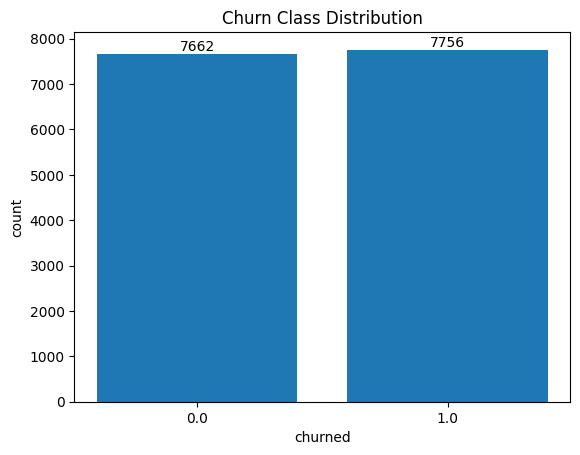

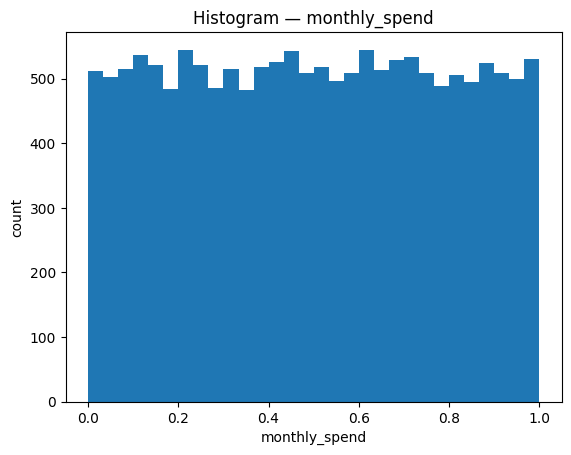

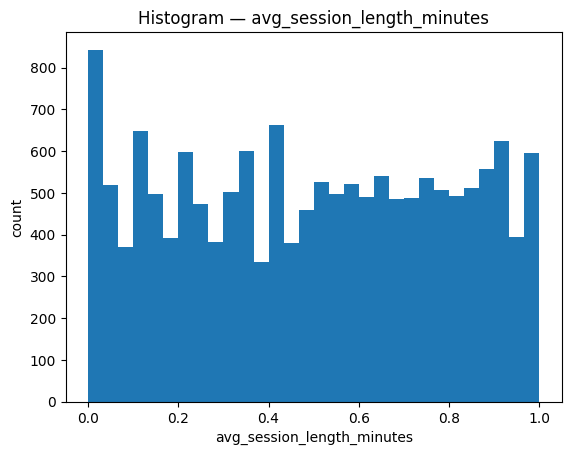

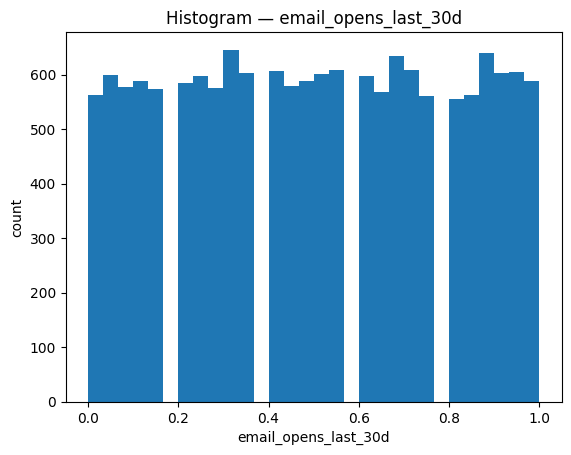

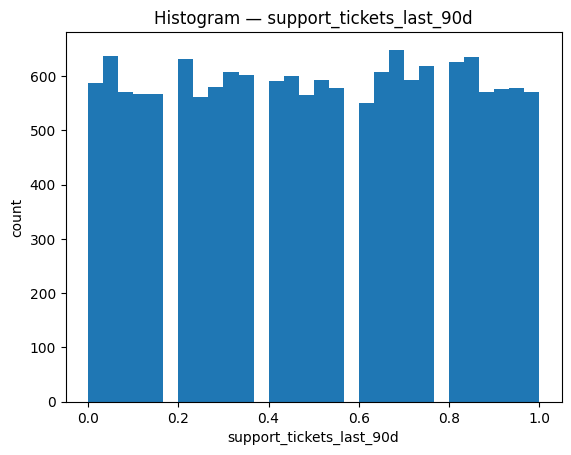

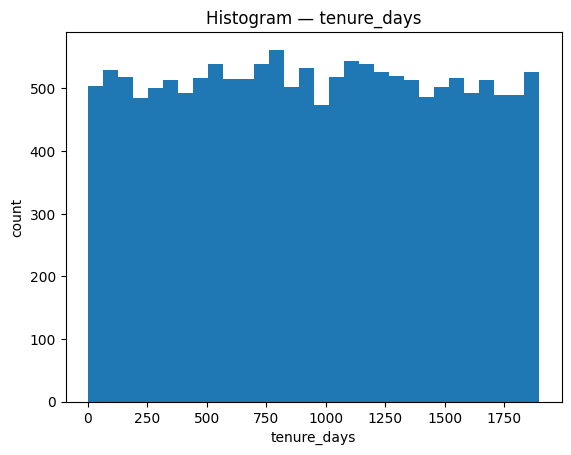

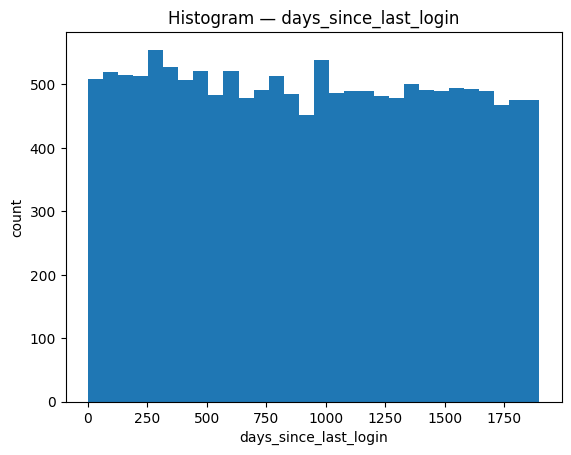

/tmp/ipython-input-1396662106.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.values, g1.values], labels=["not churned (0)", "churned (1)"])


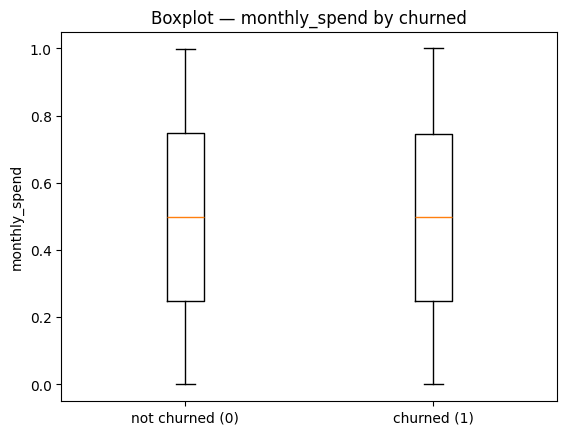

/tmp/ipython-input-1396662106.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.values, g1.values], labels=["not churned (0)", "churned (1)"])


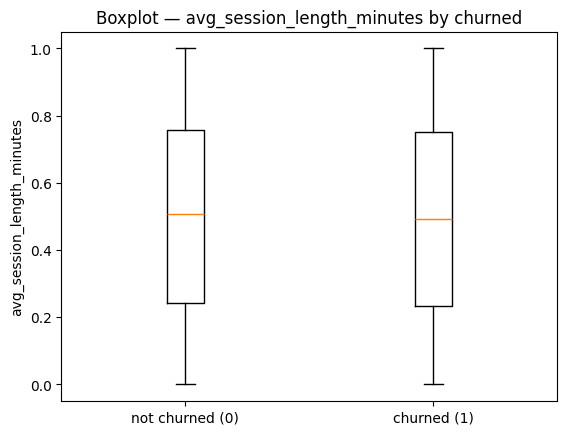

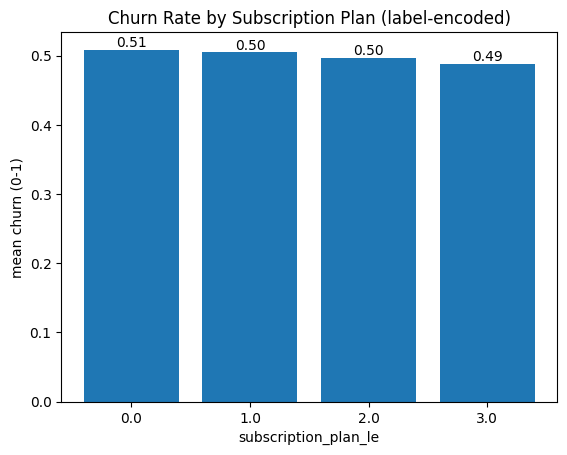

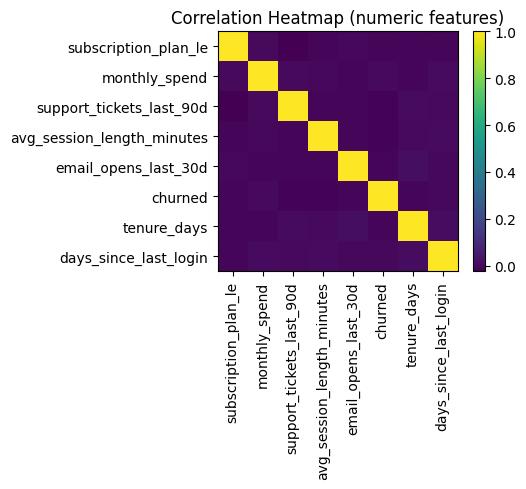

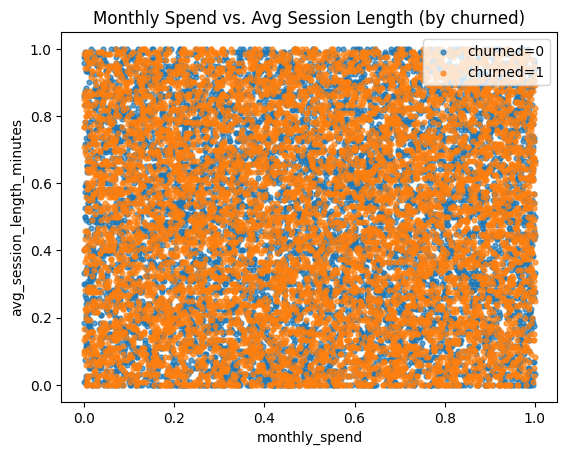

In [4]:

# --- Visualizations ---
import math

def safe_cols(candidates):
    return [c for c in candidates if c in df.columns]

# 1) Churn class distribution (bar)
if "churned" in df.columns:
    plt.figure()
    counts = df["churned"].value_counts().sort_index()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Churn Class Distribution")
    plt.xlabel("churned")
    plt.ylabel("count")
    for i, v in enumerate(counts.values):
        plt.text(i, v, str(v), ha="center", va="bottom")
    plt.show()

# 2) Histograms for key numeric features (one figure per feature)
hist_candidates = safe_cols([
    "monthly_spend",
    "avg_session_length_minutes",
    "email_opens_last_30d",
    "support_tickets_last_90d",
    "tenure_days",
    "days_since_last_login"
])
for col in hist_candidates:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

# 3) Boxplots by churned (if churned present)
def box_by_churn(feature):
    if feature in df.columns and "churned" in df.columns:
        g0 = df.loc[df["churned"] == 0, feature].dropna()
        g1 = df.loc[df["churned"] == 1, feature].dropna()
        if len(g0) or len(g1):
            plt.figure()
            plt.boxplot([g0.values, g1.values], labels=["not churned (0)", "churned (1)"])
            plt.title(f"Boxplot — {feature} by churned")
            plt.ylabel(feature)
            plt.show()

for feat in ["monthly_spend", "avg_session_length_minutes"]:
    box_by_churn(feat)

# 4) Churn rate by subscription plan (bar), if both present
if "subscription_plan_le" in df.columns and "churned" in df.columns:
    rate = df.groupby("subscription_plan_le")["churned"].mean().sort_index()
    plt.figure()
    plt.bar(rate.index.astype(str), rate.values)
    plt.title("Churn Rate by Subscription Plan (label-encoded)")
    plt.xlabel("subscription_plan_le")
    plt.ylabel("mean churn (0-1)")
    for i, v in enumerate(rate.values):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
    plt.show()

# 5) Correlation heatmap for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(max(6, 0.6*len(num_cols)), max(5, 0.6*len(num_cols))))
    im = plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Heatmap (numeric features)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# 6) Scatter: monthly_spend vs avg_session_length_minutes, colored by churned (default colors)
if set(["monthly_spend", "avg_session_length_minutes", "churned"]).issubset(df.columns):
    plt.figure()
    for label, subdf in df.groupby("churned"):
        plt.scatter(
            subdf["monthly_spend"],
            subdf["avg_session_length_minutes"],
            s=12, alpha=0.7, label=f"churned={int(label)}"
        )
    plt.title("Monthly Spend vs. Avg Session Length (by churned)")
    plt.xlabel("monthly_spend")
    plt.ylabel("avg_session_length_minutes")
    plt.legend()
    plt.show()
